# This notebook assumes that you've imported one or more NWB files into DataJoint 
# It allows you to run spikesorters on those data using the SpikeInterface package

#### Load all of the relevant modules

In [34]:
%env DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
%load_ext autoreload
%autoreload 2

import os
data_dir = '/Users/loren/data/nwb_builder_test_data'
os.environ['NWB_DATAJOINT_BASE_DIR'] = data_dir
os.environ['KACHERY_STORAGE_DIR'] = os.path.join(data_dir, 'kachery-storage')
os.environ['SORTING_TEMP_DIR'] = os.path.join(data_dir, 'sort_tmp')

import pynwb
import os

#DataJoint and DataJoint schema
import nwb_datajoint as nd
import datajoint as dj

import spikeinterface as si
import spikeextractors as se

env: DJ_SUPPORT_FILEPATH_MANAGEMENT=TRUE
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set the nwb file name and the name of the probe file to create from DataJoint

In [5]:
nwb_file_name = (nd.common.Session() & {'session_id': 'beans_01'}).fetch1('nwb_file_name')
probe_file_name = '/Users/loren/data/nwb_builder_test_data/test.prb'

In [ ]:
nd.common.SortGroup().set_group_by_shank(nwb_file_name)


In [11]:
nd.common.SortGroup.SortGroupElectrode()

nwb_file_name the name of the NWB file,sort_group_id identifier for a group of electrodes,electrode_group_name electrode group name from NWBFile,electrode_id the unique number for this electrode,"sort_reference_electrode the electrode to use for reference. -1: no reference, -2: common median"
beans20190718.nwb,0,0,0,-1
beans20190718.nwb,0,0,1,-1
beans20190718.nwb,0,0,2,-1
beans20190718.nwb,0,0,3,-1
beans20190718.nwb,0,0,4,-1
beans20190718.nwb,0,0,5,-1
beans20190718.nwb,0,0,6,-1
beans20190718.nwb,0,0,7,-1
beans20190718.nwb,0,0,8,-1
beans20190718.nwb,0,0,9,-1


In [6]:
nd.common.SortGroup().write_prb(1, nwb_file_name, probe_file_name)

In [7]:
recording = se.NwbRecordingExtractor(nd.common.Nwbfile.get_abs_path(nwb_file_name), electrical_series_name='e-series')



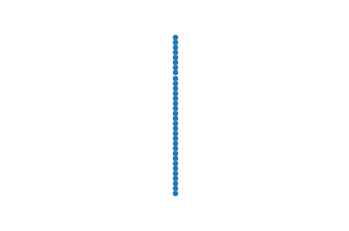

In [16]:
recording = recording.load_probe_file(probe_file_name)

import spikeinterface.widgets as sw
probe = sw.plot_electrode_geometry(recording)
#p = si.widgets.plot_electrode_geometry(recording)

In [9]:
nd.common.SpikeSorter().insert_from_spikeinterface()
nd.common.SpikeSorterParameters().insert_from_spikeinterface()



About to delete:
`common_ephys`.`spike_sorter_parameters`: 10 items
`common_ephys`.`spike_sorter`: 10 items


Proceed? [yes, No]:  yes


Committed.


/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packages/datajoint/blob.py:180: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(obj, collections.ByteString):
/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packages/datajoint/blob.py:182: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(obj, collections.MutableSequence):
/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packages/datajoint/blob.py:184: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  if isinstance(obj, collections.Sequence):
/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packages/datajoint/blob.py:186: Deprecation

In [10]:
p = (nd.common.SpikeSorterParameters() & {'sorter_name': 'mountainsort4'}).fetch1()
print(p)
param = p['parameter_dict']
param['adjacency_radius'] = 100
param['curation'] = True
param['num_workers'] = 1

{'sorter_name': 'mountainsort4', 'parameter_set_name': 'default', 'parameter_dict': {'detect_sign': -1, 'adjacency_radius': -1, 'freq_min': 300, 'freq_max': 6000, 'filter': True, 'whiten': True, 'curation': False, 'num_workers': None, 'clip_size': 50, 'detect_threshold': 3, 'detect_interval': 10, 'noise_overlap_threshold': 0.15}}


In [46]:
nd.common.SpikeSorterParameters().insert1({'sorter_name': 'mountainsort4', 'parameter_set_name' : 'franklab_mountainsort', 'parameter_dict' : param})

[autoreload of nwb_datajoint.common.common_ephys failed: Traceback (most recent call last):
  File "/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 410, in superreload
    update_generic(old_obj, new_obj)
  File "/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 302, in update_class
    if update_generic(old_obj, new_obj): continue
  File "/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 347, in update_generic
    update(a, b)
  File "/Users/loren/opt/anaconda3/envs/nwbdj/lib/python3.7/site-packag

In [93]:
import numpy as np
s1 = ((nd.common.IntervalList() & {'interval_list_name' : '01_s1'}).fetch('valid_times'))
s1


array([array([[1.56348899e+09, 1.56349008e+09]])], dtype=object)

In [11]:
second_shank_electrodes = (nd.common.SortGroup.SortGroupElectrode() & {'nwb_file_name' : nwb_file_name} & {'sort_group_id' : 1}).fetch('electrode_id')
second_shank_electrodes

array([32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48,
       49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [72]:
valid_times = (nd.common.IntervalList() & {'nwb_file_name' : nwb_file_name, 'interval_list_name' : 'raw data valid times'}).fetch('valid_times')
valid_times[0][-1,-1] 

1563497108.134555

In [44]:
valid_times[0][0,0]

1563488988.8768327

In [32]:
second_shank_recording = se.SubRecordingExtractor(recording, channel_ids=second_shank_electrodes)
second_shank_recording.frame_to_time?

Signature: second_shank_recording.frame_to_time(frame)
Docstring:
This function converts a user-inputted frame index to a time with units of seconds.

Parameters
----------
frame: float
    The frame to be converted to a time

Returns
-------
time: float
    The corresponding time in seconds
File:      ~/Src/NWB/spikeextractors/spikeextractors/subrecordingextractor.py
Type:      method


In [15]:
second_shank_sort = si.sorters.run_mountainsort4(recording=second_shank_recording, **param, grouping_property='group', output_folder='/Users/loren/data/nwb_builder_test_data/tmp')

KeyboardInterrupt: 

In [35]:
a = dict()
a[1] = 'test'

In [36]:
a[1]

'test'